Example 2.9375
==============

This notebook is available on github
[here](https://github.com/aezarebski/aas-extended-examples). If you find
errors or would like to suggest an improvement, feel free to create an
issue.

As usual we will start by importing some useful libraries.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tools.tools as smt
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Salaries for Professors

The 2008-09 nine-month academic salary for Assistant Professors, Associate Professors and Professors in a college in the U.S. The data were collected as part of the on-going effort of the college's administration to monitor salary differences between male and female faculty members.

- `rank` a factor with levels `AssocProf`` `AsstProf`` `Prof`.
- `discipline` a factor with levels `A` ("theoretical" departments) or ``B`` ("applied" departments).
- `yrs.since.phd` years since PhD.
- `yrs.service` years of service.
- `sex` a factor with levels `Female` `Male`.
- `salary` nine-month salary, in dollars.


In [4]:
salaries_dataset = sm.datasets.get_rdataset("Salaries", "carData")
#print(salaries_dataset.__doc__) #get the documentation of what each variables mean 
salaries_df = salaries_dataset.data #get the data
salaries_df = salaries_df.rename(columns={"yrs.since.phd": "years_post_phd", "yrs.service": "years_service", "rank": "job"}) #rename the columns 

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     84.23
Date:                Thu, 02 Dec 2021   Prob (F-statistic):           2.50e-18
Time:                        11:47:32   Log-Likelihood:                -4620.9
No. Observations:                 397   AIC:                             9246.
Df Residuals:                     395   BIC:                             9254.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       9.172e+04   2765.792     33.

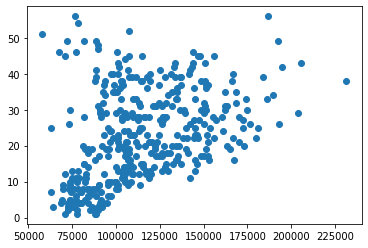

In [6]:
lm_0 = smf.ols(formula="salary ~ years_post_phd", data = salaries_df).fit() #linear regression on salary based on how many years after a phd
print(lm_0.summary()) #print summary of fitted model 
plt.figure()
plt.scatter(salaries_df.salary, salaries_df.years_post_phd) #scatter plot 
plt.show()

If we colour these points based on the professors' ranks a very different pattern emerges

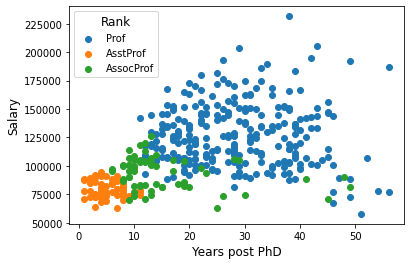

In [5]:
jobs = salaries_df["job"].unique() #find out all the unique job ranks 

    
plt.figure()
for job in jobs: #loop through every job, and plot the same scatter plot, labeled by each point's job rank 
    tmp = salaries_df[salaries_df["job"] == job] #filter for only one job rank
    plt.scatter(tmp.years_post_phd, tmp.salary, label = job) #plot the points and label the job rank 
plt.legend(title = "Rank", title_fontsize = "large")
plt.xlabel("Years post PhD", fontsize="large")
plt.ylabel("Salary", fontsize="large")
plt.show()

### Question

What assumption of the variance component model clearly does not hold for this data set?

### Answer

The within group variance is differs wildly!

In [7]:
for job in jobs:
    print(job)
    print("mean: " + str(salaries_df[salaries_df["job"] == job].salary.mean())) #mean for that job type
    print("scale: " + str(salaries_df[salaries_df["job"] == job].salary.std())) #standard deviation for that job type

Prof
mean: 126772.1090225564
scale: 27718.674998951574
AsstProf
mean: 80775.98507462686
scale: 8174.1126373976995
AssocProf
mean: 93876.4375
scale: 13831.699843745177


# Simulation

Before we analyse this data we should familiarise ourselves with the functionality provided by `statsmodels`. To have a data set where we know the "true" values we will simulate a very similar dataset.

In [ ]:
demo_job = np.repeat(a=['Prof', 'AsstProf', 'AssocProf'], repeats=100)
demo_ypp = np.concatenate(
    (stats.poisson.rvs(30, size = 100),
    stats.poisson.rvs(5, size = 100),
    stats.poisson.rvs(15, size = 100)))

demo_salary_means = [126772,80775,93876] #choose a mean where you will let your groups of salary center around 
demo_salary_scale = 15000
demo_salary = stats.norm.rvs(loc = np.repeat(a=demo_salary_means, repeats=100), scale = demo_salary_scale, size = 300)

#create a dataframe of jobs and salaries 
demo_df = pd.DataFrame({'job': demo_job,
                      'years_post_phd': demo_ypp,
                       'salary': demo_salary})
demo_df = smt.add_constant(demo_df)

jobs = demo_df["job"].unique()

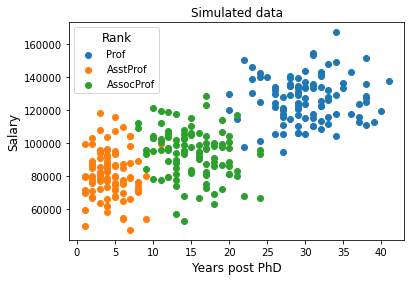

In [ ]:
#plot in the same way as before, with simulated data instead 
plt.figure()
for job in jobs:
    tmp = demo_df[demo_df["job"] == job]
    plt.scatter(tmp.years_post_phd, tmp.salary, label = job)
plt.title("Simulated data")
plt.legend(title = "Rank", title_fontsize = "large")
plt.xlabel("Years post PhD", fontsize="large")
plt.ylabel("Salary", fontsize="large")
plt.show()

### Question

As a way to get a rough idea of the components of the variance, estimate the variance among the known means and use it to compute the variance partition coefficient (VPC) for the simulated dataset. Obviously since we are estimating the variance based on a data set of size 3 we should not put too much faith in the results.

### Answer

In [ ]:
tmp = np.array(demo_salary_means)
silly_group_var_est = 0.5 * np.power(tmp - tmp.mean(), 2).sum()
print(silly_group_var_est / (demo_salary_scale**2 + silly_group_var_est)) #ball park estimate on the varianve between the means of each group

0.7139531750746885


To do MLM we need some additional libraries. The `MixedLM` class ([link](https://www.statsmodels.org/stable/generated/statsmodels.regression.mixed_linear_model.MixedLM.html#statsmodels.regression.mixed_linear_model.MixedLM)) is the one we will be interested in.

In [ ]:
import statsmodels.regression.mixed_linear_model as mlm #mixed linear model 

### Question

Write down a way to describe the salaries with a variance components model. What parameters will be estimated?

### Answer

Let $s_{ij}$ be the salary of individual $i$ with job $j$ then

$$
s_{ij} = \beta_{0} + u_{j} + e_{ij}
$$

where $u_{j} \sim N(0, \sigma_{u}^{2})$ and $e_{ij} \sim N(0, \sigma_{e}^{2})$.

The parameters that will be estimated are $\beta_{0}$, and $\sigma_{u}^{2}$ and $\sigma_{e}^{2}$.

### Question

The following cell fits this model to the data. What are the estimated parameter values?

Hint: Due to an odd choice of names, the "Scale" parameter in the summary is the individual level variance.

In [ ]:
#endogenous = what you want to predict; exogeneous = what you will use to predict
mlm_0 = mlm.MixedLM(endog = demo_df.salary, exog = demo_df[["const"]], groups = demo_df.job).fit()  
mlm_0.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
==================================================================
Model:              MixedLM   Dependent Variable:   salary        
No. Observations:   300       Method:               REML          
No. Groups:         3         Scale:                204305624.3905
Min. group size:    100       Log-Likelihood:       -3293.4138    
Max. group size:    100       Converged:            Yes           
Mean group size:    100.0                                         
------------------------------------------------------------------
              Coef.      Std.Err.   z   P>|z|   [0.025    0.975]  
------------------------------------------------------------------
const        100587.861 13555.156 7.421 0.000 74020.244 127155.478
Group Var 549183677.025 38655.470                                 
==================================================================

"""

### Answer

- $\hat{\beta}_{0} = 1.005 \times 10^{5}$
- $\hat{\sigma}_{u}^{2} = 5.482 \times 10^{8}$
- $\hat{\sigma}_{e}^{2} = 2.333 \times 10^{8}$

### Question

Does this look reasonable?

### Answer

The value of $\beta_{0}$ looks reasonable and the individual level variance is approximately correct.

In [ ]:
# truth is 15,000
individual_var_est = mlm_0.scale
print(np.sqrt(individual_var_est)) #estimated variance 
print(demo_salary_scale) #real variance 

14293.551846568334
15000


### Question

Compute the VPC from the model fit. Does it agree with the previous estimate?

### Answer 

Yes

In [ ]:
group_var = float(mlm_0.summary().tables[1]["Coef."]["Group Var"])
vpc = group_var / (group_var + individual_var_est) #look at group variance as a fraction of overall variance 
print(vpc) #similar to our ball park estimate 

0.7288539810628767


### Question

Test whether including the effects of job is important in this model.

### Answer

The case of no job level effect is a nested model so we can use a chi-squared test to reject the null hypothesis that there is no random effect at the job level. Ho: There is no effect of job rank on salaries Ha: There is an effect of job rank on salaries. 

In [ ]:
lm_1 = smf.ols(formula = "salary ~ 1", data = demo_df).fit()
mlm_llhd = mlm_0.llf
print("MLM log-likelihood")
print(mlm_llhd)

lm_llhd = lm_1.llf
print("LM log-likelihood")
print(lm_llhd)

my_chi = -2 * (lm_llhd - mlm_llhd) #degree of freedom is the number of parameter we have to take away for the hypothesis testing? 
print("Chi-squared statistic") #big chi squared meaning difference between groups variance is significant 
print(my_chi)

print("p-value")
print(1 - stats.chi2.cdf(my_chi, df=1)) #reject the null hypothesis, job rank has an effect on salaries

MLM log-likelihood
-3293.4137866637348
LM log-likelihood
-3449.8839709259773
Chi-squared statistic
312.94036852448517
p-value
0.0


### Question 

Fit the model including the `years_post_phd` as a covariate. Does this parameter have a significant association?

### Answer

No, as expected since the salaries were simulated independent of this value (given the job).

In [ ]:
mlm_1 = mlm.MixedLM(endog = demo_df.salary, exog = demo_df[["const", "years_post_phd"]], groups = demo_df.job).fit()
mlm_1.summary()
#years post phd has a big p value (low z) so it is not significant in determining salaries 

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                MixedLM     Dependent Variable:     salary        
No. Observations:     300         Method:                 REML          
No. Groups:           3           Scale:                  204129652.9008
Min. group size:      100         Log-Likelihood:         -3286.6798    
Max. group size:      100         Converged:              Yes           
Mean group size:      100.0                                             
------------------------------------------------------------------------
                   Coef.      Std.Err.   z    P>|z|   [0.025    0.975]  
------------------------------------------------------------------------
const             104021.255 15651.341  6.646 0.000 73345.190 134697.320
years_post_phd      -206.956   229.920 -0.900 0.368  -657.591    243.680
Group Var      689203694.272 49734.689                                  
========================================================================

"""

### Question

Apply the methodology above to establish if `years_post_phd` has a significant association with a Professor's salary while adjusting for random job-specific effects.

### Answer

This model does not find a significant correlation

In [ ]:
data_df = smt.add_constant(salaries_df) #add a constant to the df's first column 
data_df[["const", "years_post_phd"]].head() 

mlm_1 = mlm.MixedLM(endog = data_df.salary, exog = data_df[["const", "years_post_phd"]], groups = data_df.job).fit() #different linear model for each group

mlm_1.summary() #p value is still big (small z) so it is not significant 

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                MixedLM     Dependent Variable:     salary        
No. Observations:     397         Method:                 REML          
No. Groups:           3           Scale:                  559427686.2493
Min. group size:      64          Log-Likelihood:         -4551.4182    
Max. group size:      266         Converged:              Yes           
Mean group size:      132.3                                             
------------------------------------------------------------------------
                   Coef.      Std.Err.   z    P>|z|   [0.025    0.975]  
------------------------------------------------------------------------
const             101625.056 14327.729  7.093 0.000 73543.223 129706.889
years_post_phd       -64.770   129.922 -0.499 0.618  -319.413    189.874
Group Var      596087722.791 25613.757                                  
========================================================================

"""

### Question

How much of the variance is explained by the professors rank?

### Answer

In [ ]:
596087722.791 / (559427686.2493 + 596087722.791)

0.5158630669287863